In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [2]:
from __future__ import absolute_import, division, print_function

import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Patch

from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow.keras
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
# Global plot settings
from matplotlib import rc
import matplotlib.font_manager

rc('font', family='serif')
rc('text', usetex=True)
rc('font', size=22)
rc('xtick', labelsize=15)
rc('ytick', labelsize=15)
rc('legend', fontsize=15)

In [4]:
# Define default plot styles
plot_style_0 = {
    'histtype': 'step',
    'color': 'black',
    'linewidth': 2,
    'linestyle': '--',
    'density': True
}

plot_style_1 = {
    'histtype': 'step',
    'color': 'black',
    'linewidth': 2,
    'density': True
}

plot_style_2 = {'histtype': 'stepfilled', 'alpha': 0.5, 'density': True}

plot_style_3 = {'histtype': 'step', 'linewidth': 2, 'alpha':0.5, 'density': True}

In [5]:
# Check Versions
print(tf.__version__)  # 2.2.0
print(tf.keras.__version__)  # 2.3.0-tf

2.2.0
2.3.0-tf


# OmniFold Gaussian Toy Example

We will unfold the same data but with two cases:

(a) there are no generation MC weights from simulated events.

(b) there are generation MC weights from simulated events.

## Setup the Datasets

In [6]:
mu0 = 0
sigma0 = 1

In [7]:
N = 10**6
# param = (mu, sigma)
sim_param = (mu0, sigma0)  # synthetic sample
data_param = (1, 1.5)  # this is the data (the target)
epsilon = sigma0 / 1.  # Smearing width

sim_truth = np.random.normal(sim_param[0], sim_param[1],
                             N)  # Generator-level synthetic sample

# Toy MC weights from "MC sampling"
weights_MC_sim = np.array([
    (np.random.normal(abs(x), epsilon)) for x in sim_truth
])  # Detector smearing for synthetic sample
sim_reco = np.array([(x + np.random.normal(0, epsilon)) for x in sim_truth
                     ])  # Detector smearing for synthetic sample
sim = np.stack([sim_truth, sim_reco], axis=1)
labels0 = np.zeros(len(sim))

data_truth = np.random.normal(data_param[0], data_param[1], N)
# Toy MC weights from "MC sampling"
weights_MC_data = np.array([(np.random.normal(abs(x), epsilon))
                            for x in data_truth])
# Detector smearing for synthetic sample
data_reco = np.array([(x + np.random.normal(0, epsilon)) for x in data_truth])
data = np.stack([data_truth, data_reco], axis=1)
labels_unknown = np.ones(len(data))

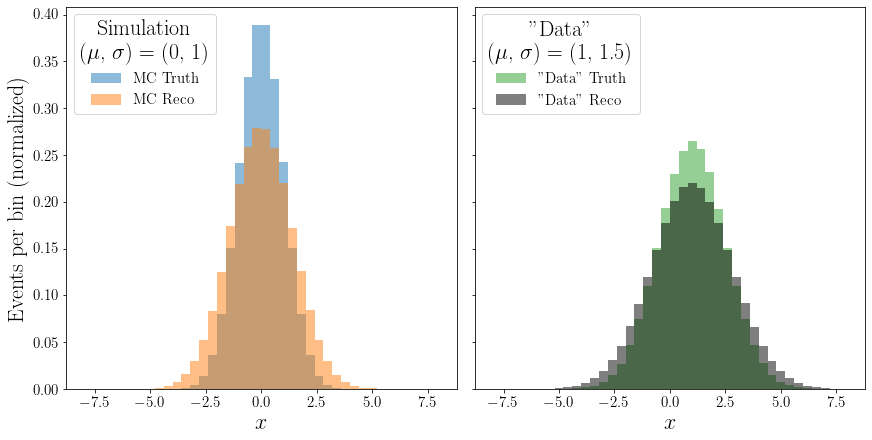

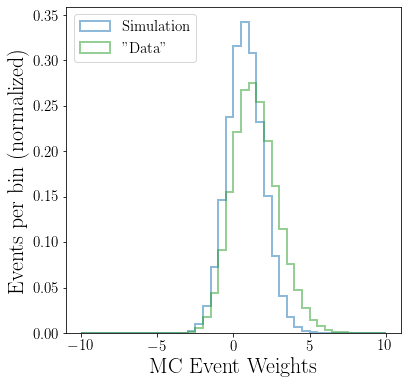

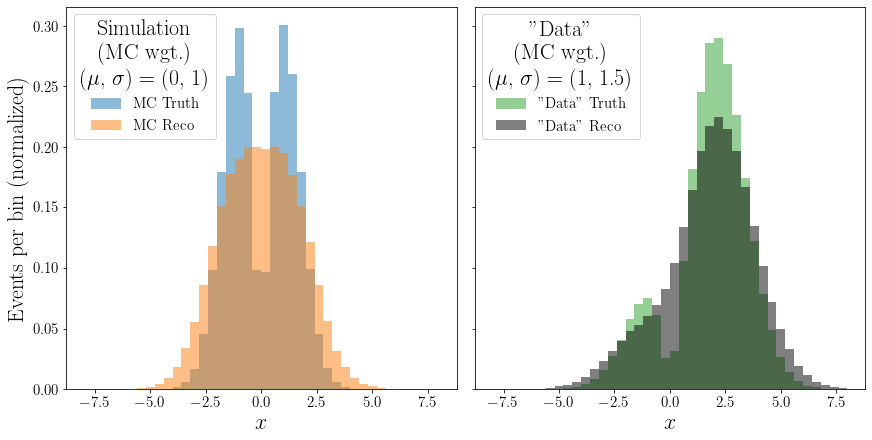

In [8]:
bins = np.linspace(-8, 8, 41)

fig, ax = plt.subplots(1,
                       2,
                       figsize=(12, 6),
                       constrained_layout=True,
                       sharey=True)

ax[0].set_xlabel('$x$')
ax[0].set_ylabel('Events per bin (normalized)')
ax[0].hist(sim_truth, bins=bins, **plot_style_2, label='MC Truth')
ax[0].hist(sim_reco, bins=bins, **plot_style_2, label='MC Reco')
legend = ax[0].legend(
    title='Simulation\n($\mu$, $\sigma$) = {}'.format(sim_param),
    loc='upper left',
    frameon=True)
plt.setp(legend.get_title(), multialignment='center')

ax[1].set_xlabel('$x$')
ax[1].hist(data_truth,
           bins=bins,
           **plot_style_2,
           color='C2',
           label='"Data" Truth')
ax[1].hist(data_reco, bins=bins, **plot_style_2, color='k', label='"Data" Reco')
legend = ax[1].legend(
    title='"Data"\n($\mu$, $\sigma$) = {}'.format(data_param),
    loc='upper left',
    frameon=True)
plt.setp(legend.get_title(), multialignment='center')
fig.savefig(
    'SupportNote/figures/GaussianToyExample/GaussianToyExample-Distributions.pdf',
    bbox_inches='tight')
fig.show()

weight_bins = np.linspace( -10, 10, 41)

plt.figure(figsize=(6,6))
plt.hist(weights_MC_sim, bins = weight_bins, color = 'C0', **plot_style_3, label = 'Simulation')
plt.hist(weights_MC_data, bins = weight_bins, color = 'C2', **plot_style_3, label = '"Data"')
plt.xlabel("MC Event Weights")
plt.ylabel("Events per bin (normalized)")
plt.legend(loc='upper left')
plt.show()

fig, ax = plt.subplots(1,
                       2,
                       figsize=(12, 6),
                       constrained_layout=True,
                       sharey=True)

ax[0].set_xlabel('$x$')
ax[0].set_ylabel('Events per bin (normalized)')
ax[0].hist(sim_truth,
           weights=weights_MC_sim,
           bins=bins,
           **plot_style_2,
           label='MC Truth')
ax[0].hist(sim_reco,
           weights=weights_MC_sim,
           bins=bins,
           **plot_style_2,
           label='MC Reco')
legend = ax[0].legend(
    title='Simulation \n(MC wgt.)\n($\mu$, $\sigma$) = {}'.format(sim_param),
    loc='upper left',
    frameon=True)
plt.setp(legend.get_title(), multialignment='center')

ax[1].set_xlabel('$x$')
ax[1].hist(data_truth,
           weights=weights_MC_data,
           bins=bins,
           **plot_style_2,
           color='C2',
           label='"Data" Truth')
ax[1].hist(data_reco,
           weights=weights_MC_data,
           bins=bins,
           **plot_style_2,
           color='k',
           label='"Data" Reco')
legend = ax[1].legend(
    title='"Data" \n(MC wgt.)\n($\mu$, $\sigma$) = {}'.format(data_param),
    loc='upper left',
    frameon=True)
plt.setp(legend.get_title(), multialignment='center')
fig.savefig(
    'SupportNote/figures/GaussianToyExample/GaussianToyExample-MCDistributions.pdf',
    bbox_inches='tight')
fig.show()

## Unfold Data

In [9]:
# Binary crossentropy for classifying two samples with weights
# Weights are "hidden" by zipping in y_true (the labels)

def weighted_binary_crossentropy(y_true, y_pred):
    weights = tf.gather(y_true, [1], axis=1) # event weights
    y_true = tf.gather(y_true, [0], axis=1) # actual y_true for loss
    
    # Clip the prediction value to prevent NaN's and Inf's
    epsilon = K.epsilon()
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)

    t_loss = -weights * ((y_true) * K.log(y_pred) +
                         (1 - y_true) * K.log(1 - y_pred))
    
    return K.mean(t_loss)

In [10]:
iterations = 10
batch_size= 10000

In [11]:
xvals_1 = np.concatenate((sim_reco, data_reco))
yvals_1 = np.concatenate((labels0, labels_unknown))

xvals_2 = np.concatenate((sim_truth, sim_truth))
yvals_2 = np.concatenate((labels0, labels_unknown))

weights = np.empty(shape=(iterations, 2, len(sim)))
# shape = (iteration, step, event)

inputs = Input((1, ))
hidden_layer_1 = Dense(50, activation='relu')(inputs)
hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
outputs = Dense(1, activation='sigmoid')(hidden_layer_3)

model = Model(inputs=inputs, outputs=outputs)

earlystopping = EarlyStopping(patience=10,
                              verbose=1,
                              restore_best_weights=True)

In [12]:
# from NN (DCTR)
def reweight(events):
    f = model.predict(events, batch_size=1000)
    weights = f / (1. - f)
    return np.squeeze(weights)

### Unfold without initial MC weights

In [13]:
# initial iterative weights are ones

weights_pull = np.ones(len(sim_reco))
weights_push = np.ones(len(sim_reco))

weight_bins = np.linspace(0, 5, 41)

In [14]:
for i in range(iterations):
    print("\nITERATION: {}\n".format(i + 1))

    # STEP 1: classify MC Reco (which is reweighted by weights_push) to "Data" Reco
    # weights reweighted MC Reco --> "Data" Reco
    print("STEP 1\n")

    weights_1 = np.concatenate((weights_push, np.ones(len(data_reco))))
    # actual weights for MC Reco, ones for "Data" Reco (not MC weights)

    X_train_1, X_test_1, Y_train_1, Y_test_1, w_train_1, w_test_1 = train_test_split(
        xvals_1, yvals_1, weights_1)
    
    # zip ("hide") the weights with the labels
    Y_train_1 = np.stack((Y_train_1, w_train_1), axis=1)
    Y_test_1 = np.stack((Y_test_1, w_test_1), axis=1)
    
    
    model.compile(loss=weighted_binary_crossentropy,
                  optimizer='Adam',
                  metrics=['accuracy'])
    model.fit(X_train_1,
              Y_train_1,
              epochs=200,
              batch_size=batch_size,
              validation_data=(X_test_1, Y_test_1),
              callbacks=[earlystopping],
              verbose=1)

    weights_pull = weights_push * reweight(sim_reco)
    weights[i, :1, :] = weights_pull

    # STEP 2: classify MC Truth to reweighted MC Truth (which is reweighted by weights_pull)
    # weights MC Truth --> reweighted MC Truth
    print("\nSTEP 2\n")

    weights_2 = np.concatenate((np.ones(len(sim_truth)), weights_pull))
    # ones for MC Truth (not MC weights), actual weights for (reweighted) MC Truth

    X_train_2, X_test_2, Y_train_2, Y_test_2, w_train_2, w_test_2 = train_test_split(
        xvals_2, yvals_2, weights_2)
    
    # zip ("hide") the weights with the labels
    Y_train_2 = np.stack((Y_train_2, w_train_2), axis=1)
    Y_test_2 = np.stack((Y_test_2, w_test_2), axis=1)

    model.compile(loss=weighted_binary_crossentropy,
                  optimizer='Adam',
                  metrics=['accuracy'])
    model.fit(X_train_2,
              Y_train_2,
              epochs=200,
              batch_size=batch_size,
              validation_data=(X_test_2, Y_test_2),
              callbacks=[earlystopping],
              verbose=1)

    weights_push = reweight(sim_truth)
    weights[i, 1:2, :] = weights_push


ITERATION: 1

STEP 1

Epoch 1/200
150/150 [==============================] - 0s 3ms/step - loss: 0.6397 - accuracy: 0.5185 - val_loss: 0.6362 - val_accuracy: 0.4952
Epoch 2/200
150/150 [==============================] - 0s 2ms/step - loss: 0.6363 - accuracy: 0.4992 - val_loss: 0.6362 - val_accuracy: 0.5066
Epoch 3/200
150/150 [==============================] - 0s 3ms/step - loss: 0.6362 - accuracy: 0.5001 - val_loss: 0.6360 - val_accuracy: 0.5052
Epoch 4/200
150/150 [==============================] - 0s 3ms/step - loss: 0.6362 - accuracy: 0.5006 - val_loss: 0.6361 - val_accuracy: 0.5062
Epoch 5/200
150/150 [==============================] - 0s 3ms/step - loss: 0.6361 - accuracy: 0.5008 - val_loss: 0.6360 - val_accuracy: 0.4950
Epoch 6/200
150/150 [==============================] - 0s 3ms/step - loss: 0.6361 - accuracy: 0.5006 - val_loss: 0.6361 - val_accuracy: 0.4943
Epoch 7/200
150/150 [==============================] - 0s 3ms/step - loss: 0.6361 - accuracy: 0.5014 - val_loss: 0.6359

150/150 [==============================] - 0s 2ms/step - loss: 0.6248 - accuracy: 0.3096 - val_loss: 0.6250 - val_accuracy: 0.3120
Epoch 9/200
150/150 [==============================] - 0s 2ms/step - loss: 0.6248 - accuracy: 0.3099 - val_loss: 0.6251 - val_accuracy: 0.3104
Epoch 10/200
150/150 [==============================] - 0s 2ms/step - loss: 0.6248 - accuracy: 0.3094 - val_loss: 0.6250 - val_accuracy: 0.3084
Epoch 11/200
150/150 [==============================] - 0s 2ms/step - loss: 0.6248 - accuracy: 0.3091 - val_loss: 0.6252 - val_accuracy: 0.3124
Epoch 12/200
150/150 [==============================] - 0s 2ms/step - loss: 0.6248 - accuracy: 0.3096 - val_loss: 0.6250 - val_accuracy: 0.3111
Epoch 13/200
150/150 [==============================] - 0s 2ms/step - loss: 0.6248 - accuracy: 0.3096 - val_loss: 0.6250 - val_accuracy: 0.3090
Epoch 14/200
150/150 [==============================] - 0s 2ms/step - loss: 0.6248 - accuracy: 0.3096 - val_loss: 0.6250 - val_accuracy: 0.3064
Epoch 

150/150 [==============================] - 0s 3ms/step - loss: 0.6843 - accuracy: 0.3866 - val_loss: 0.6866 - val_accuracy: 0.3550
Epoch 11/200
150/150 [==============================] - 0s 2ms/step - loss: 0.6843 - accuracy: 0.3863 - val_loss: 0.6870 - val_accuracy: 0.3897
Epoch 12/200
150/150 [==============================] - 0s 2ms/step - loss: 0.6843 - accuracy: 0.3819 - val_loss: 0.6865 - val_accuracy: 0.3633
Epoch 13/200
150/150 [==============================] - 0s 2ms/step - loss: 0.6842 - accuracy: 0.3830 - val_loss: 0.6864 - val_accuracy: 0.3763
Epoch 14/200
150/150 [==============================] - 0s 2ms/step - loss: 0.6843 - accuracy: 0.3841 - val_loss: 0.6870 - val_accuracy: 0.3846
Epoch 15/200
150/150 [==============================] - 0s 2ms/step - loss: 0.6843 - accuracy: 0.3875 - val_loss: 0.6872 - val_accuracy: 0.4049
Epoch 16/200
150/150 [==============================] - 0s 2ms/step - loss: 0.6844 - accuracy: 0.3851 - val_loss: 0.6870 - val_accuracy: 0.4144
Epoch

150/150 [==============================] - 0s 2ms/step - loss: 0.6924 - accuracy: 0.3302 - val_loss: 0.6925 - val_accuracy: 0.3753
Epoch 34/200
150/150 [==============================] - 0s 2ms/step - loss: 0.6924 - accuracy: 0.3403 - val_loss: 0.6924 - val_accuracy: 0.3651
Epoch 00034: early stopping

STEP 2

Epoch 1/200
150/150 [==============================] - 0s 3ms/step - loss: 0.6087 - accuracy: 0.3081 - val_loss: 0.5923 - val_accuracy: 0.2981
Epoch 2/200
150/150 [==============================] - 0s 2ms/step - loss: 0.5927 - accuracy: 0.2977 - val_loss: 0.5922 - val_accuracy: 0.2992
Epoch 3/200
150/150 [==============================] - 0s 2ms/step - loss: 0.5926 - accuracy: 0.2981 - val_loss: 0.5922 - val_accuracy: 0.2970
Epoch 4/200
150/150 [==============================] - 0s 3ms/step - loss: 0.5927 - accuracy: 0.2977 - val_loss: 0.5923 - val_accuracy: 0.2963
Epoch 5/200
150/150 [==============================] - 0s 3ms/step - loss: 0.5927 - accuracy: 0.2978 - val_loss: 0.5

150/150 [==============================] - 0s 2ms/step - loss: 0.5929 - accuracy: 0.2981 - val_loss: 0.5930 - val_accuracy: 0.2972
Epoch 8/200
150/150 [==============================] - 0s 2ms/step - loss: 0.5930 - accuracy: 0.2983 - val_loss: 0.5931 - val_accuracy: 0.2992
Epoch 9/200
150/150 [==============================] - 0s 2ms/step - loss: 0.5929 - accuracy: 0.2982 - val_loss: 0.5931 - val_accuracy: 0.2973
Epoch 10/200
150/150 [==============================] - 0s 3ms/step - loss: 0.5929 - accuracy: 0.2984 - val_loss: 0.5931 - val_accuracy: 0.2960
Epoch 11/200
150/150 [==============================] - 0s 3ms/step - loss: 0.5929 - accuracy: 0.2979 - val_loss: 0.5931 - val_accuracy: 0.2989
Epoch 12/200
150/150 [==============================] - 0s 3ms/step - loss: 0.5929 - accuracy: 0.2983 - val_loss: 0.5930 - val_accuracy: 0.2980
Epoch 00012: early stopping

ITERATION: 7

STEP 1

Epoch 1/200
150/150 [==============================] - 0s 3ms/step - loss: 0.7137 - accuracy: 0.3566

150/150 [==============================] - 0s 3ms/step - loss: 0.5969 - accuracy: 0.2982 - val_loss: 0.5965 - val_accuracy: 0.2998
Epoch 10/200
150/150 [==============================] - 0s 3ms/step - loss: 0.5969 - accuracy: 0.2981 - val_loss: 0.5965 - val_accuracy: 0.3001
Epoch 11/200
150/150 [==============================] - 0s 3ms/step - loss: 0.5969 - accuracy: 0.2985 - val_loss: 0.5965 - val_accuracy: 0.2997
Epoch 12/200
150/150 [==============================] - 0s 3ms/step - loss: 0.5969 - accuracy: 0.2983 - val_loss: 0.5965 - val_accuracy: 0.2982
Epoch 00012: early stopping

ITERATION: 9

STEP 1

Epoch 1/200
150/150 [==============================] - 0s 3ms/step - loss: 0.7192 - accuracy: 0.3602 - val_loss: 0.6899 - val_accuracy: 0.4530
Epoch 2/200
150/150 [==============================] - 0s 2ms/step - loss: 0.6955 - accuracy: 0.3763 - val_loss: 0.6898 - val_accuracy: 0.3306
Epoch 3/200
150/150 [==============================] - 0s 3ms/step - loss: 0.6951 - accuracy: 0.3658

150/150 [==============================] - 0s 2ms/step - loss: 0.6948 - accuracy: 0.3415 - val_loss: 0.6982 - val_accuracy: 0.3072
Epoch 15/200
150/150 [==============================] - 0s 3ms/step - loss: 0.6948 - accuracy: 0.3557 - val_loss: 0.6990 - val_accuracy: 0.2520
Epoch 16/200
150/150 [==============================] - 0s 2ms/step - loss: 0.6950 - accuracy: 0.3497 - val_loss: 0.6988 - val_accuracy: 0.4963
Epoch 17/200
150/150 [==============================] - 0s 2ms/step - loss: 0.6948 - accuracy: 0.3528 - val_loss: 0.6984 - val_accuracy: 0.2846
Epoch 18/200
150/150 [==============================] - 0s 3ms/step - loss: 0.6949 - accuracy: 0.3380 - val_loss: 0.6987 - val_accuracy: 0.4972
Epoch 19/200
150/150 [==============================] - 0s 3ms/step - loss: 0.6948 - accuracy: 0.3554 - val_loss: 0.6984 - val_accuracy: 0.2712
Epoch 20/200
150/150 [==============================] - 0s 3ms/step - loss: 0.6948 - accuracy: 0.3340 - val_loss: 0.6983 - val_accuracy: 0.2949
Epoch

#### Results

ITERATION 1:


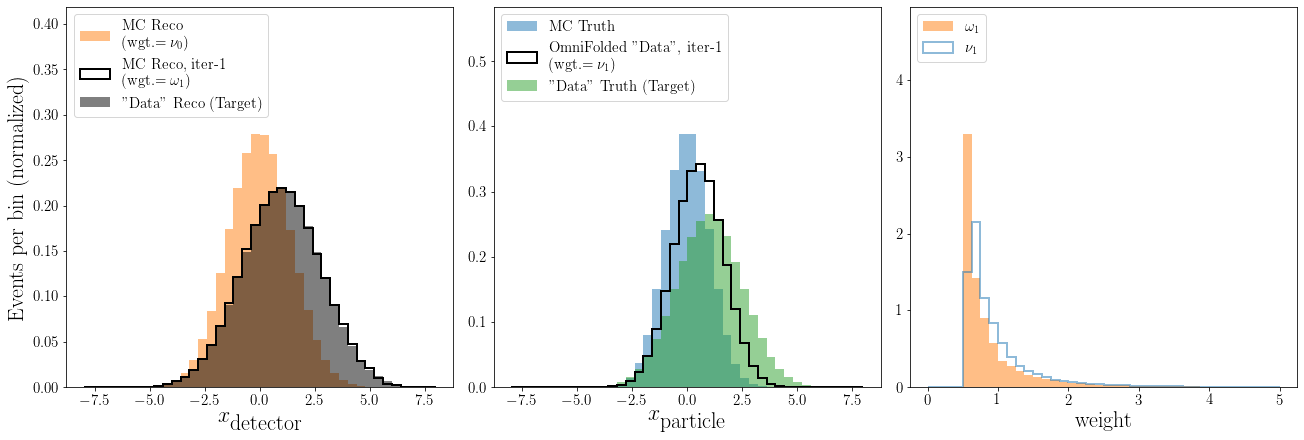

ITERATION 2:


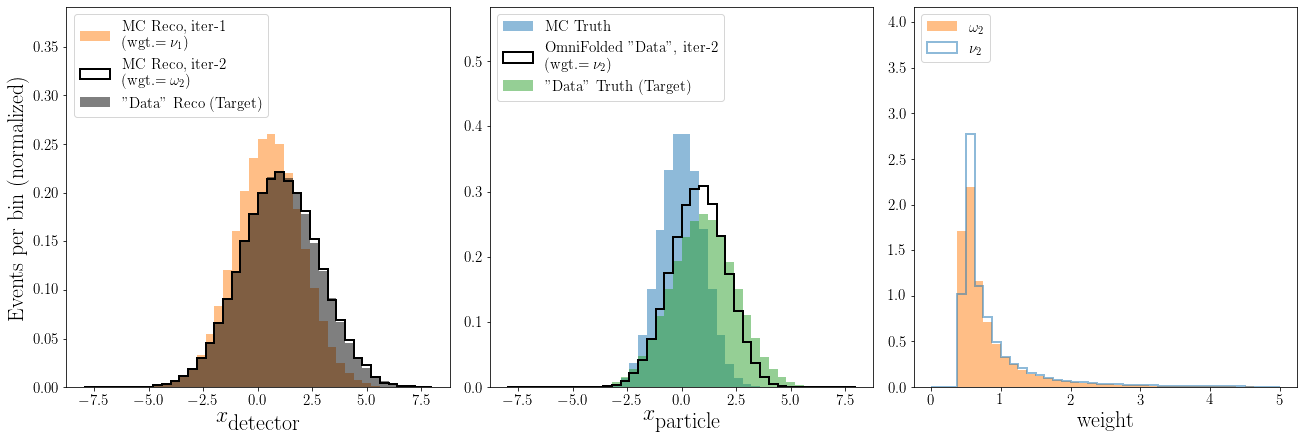

ITERATION 3:


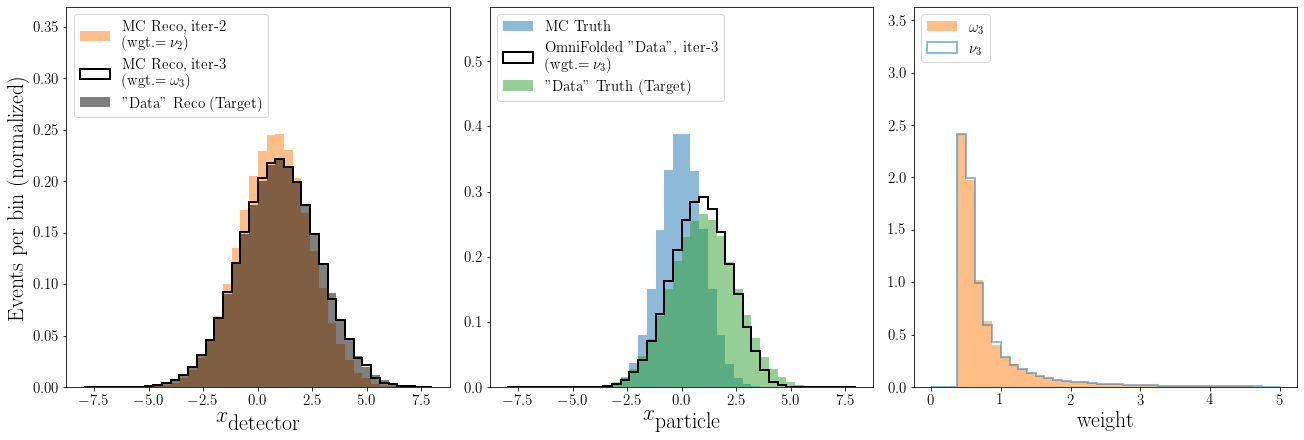

ITERATION 4:


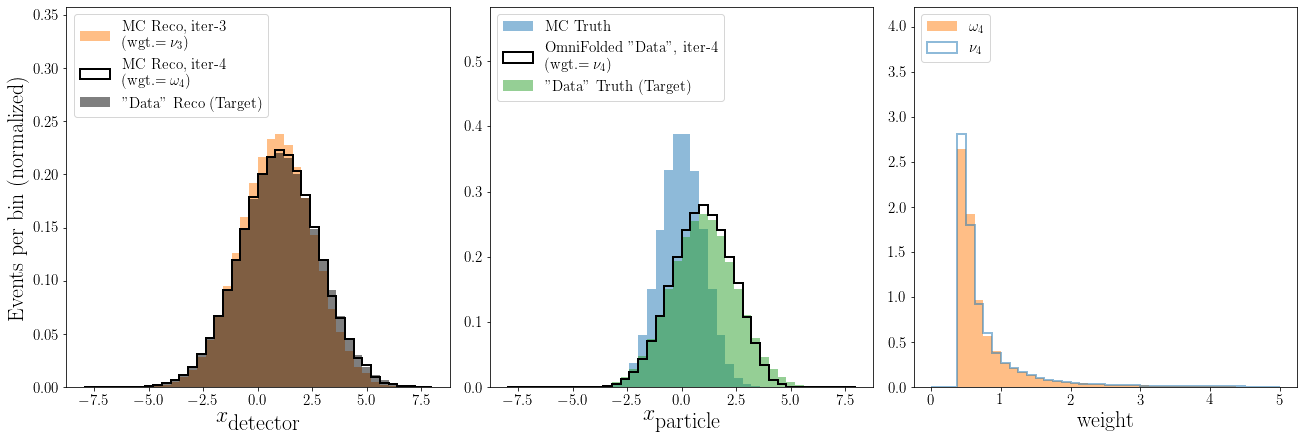

ITERATION 5:


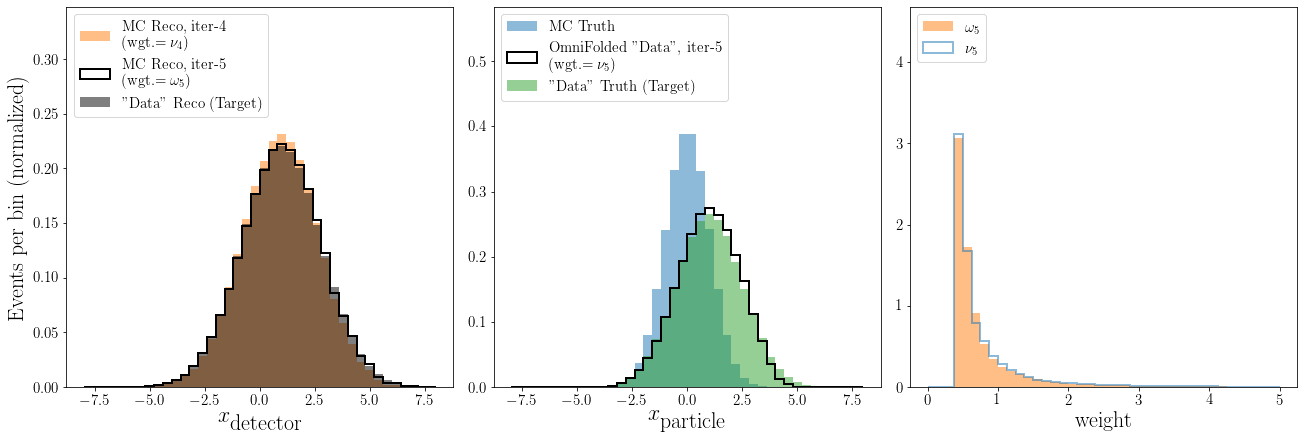

ITERATION 6:


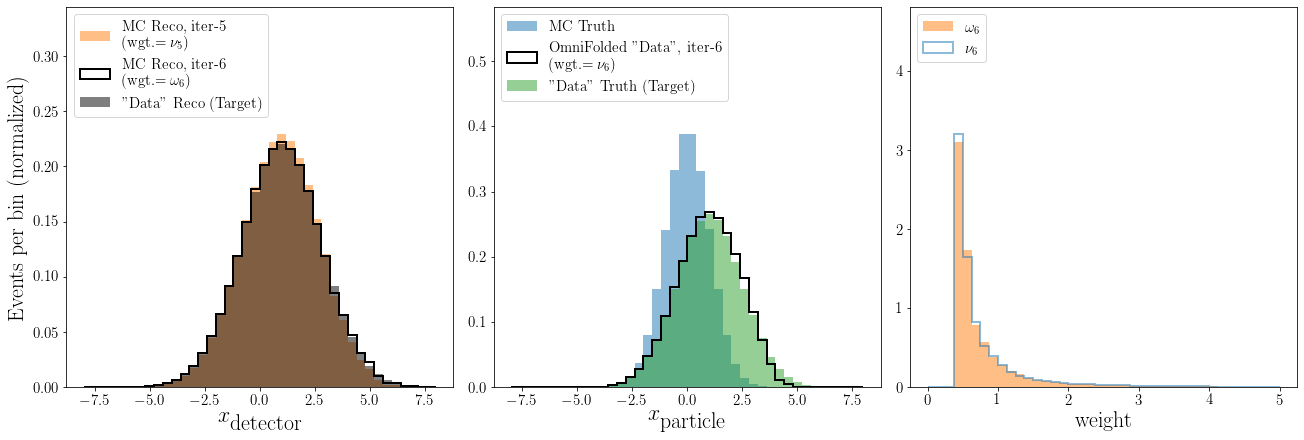

ITERATION 7:


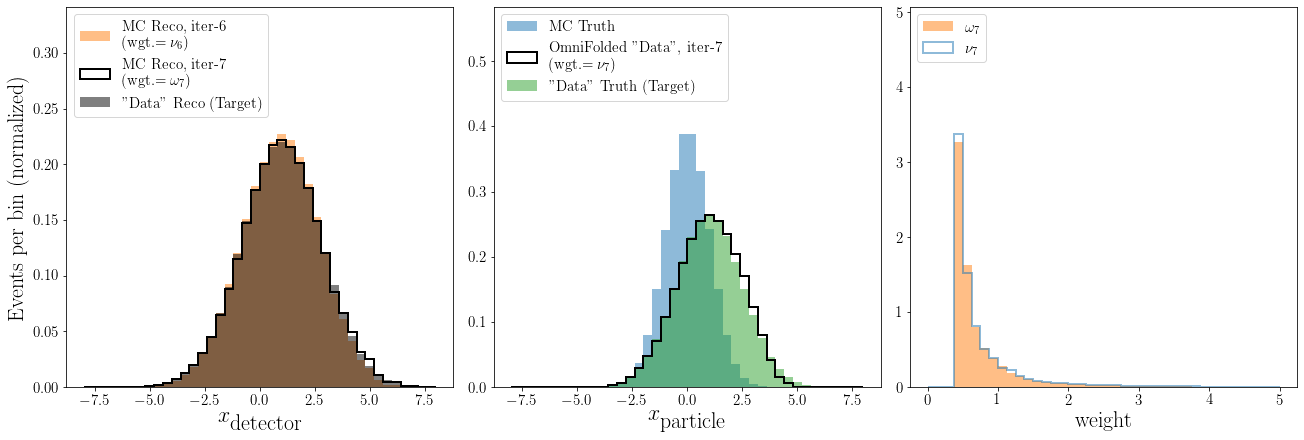

ITERATION 8:


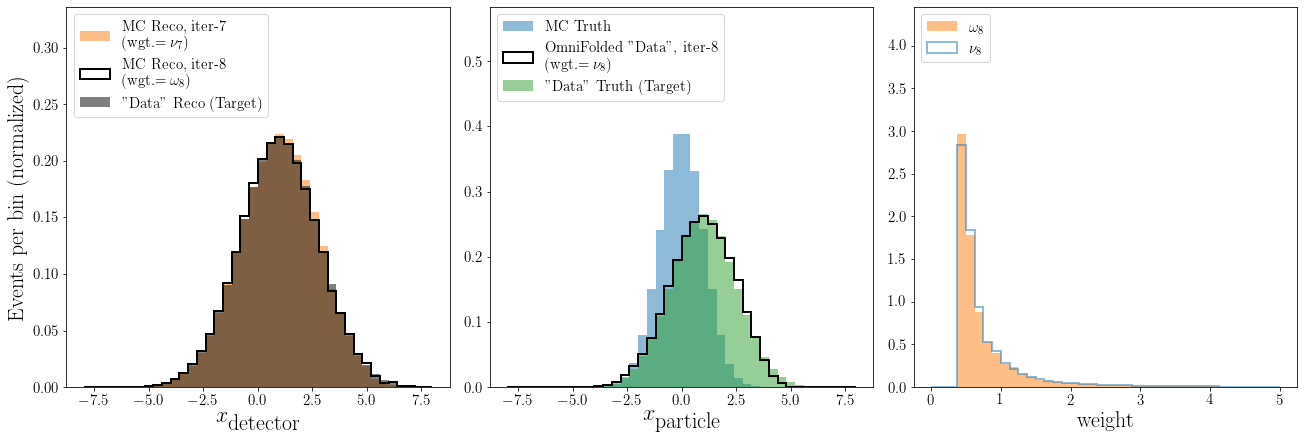

ITERATION 9:


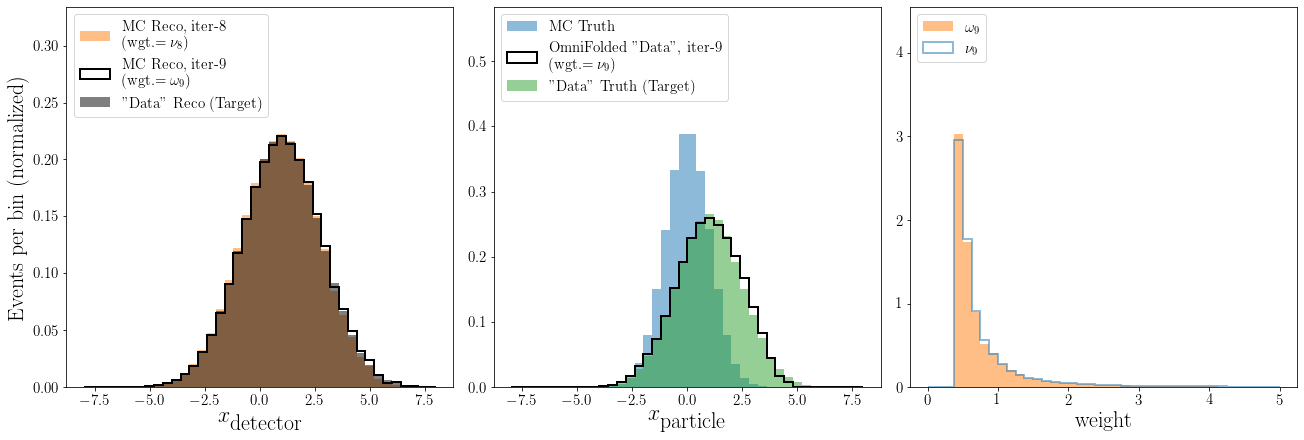

ITERATION 10:


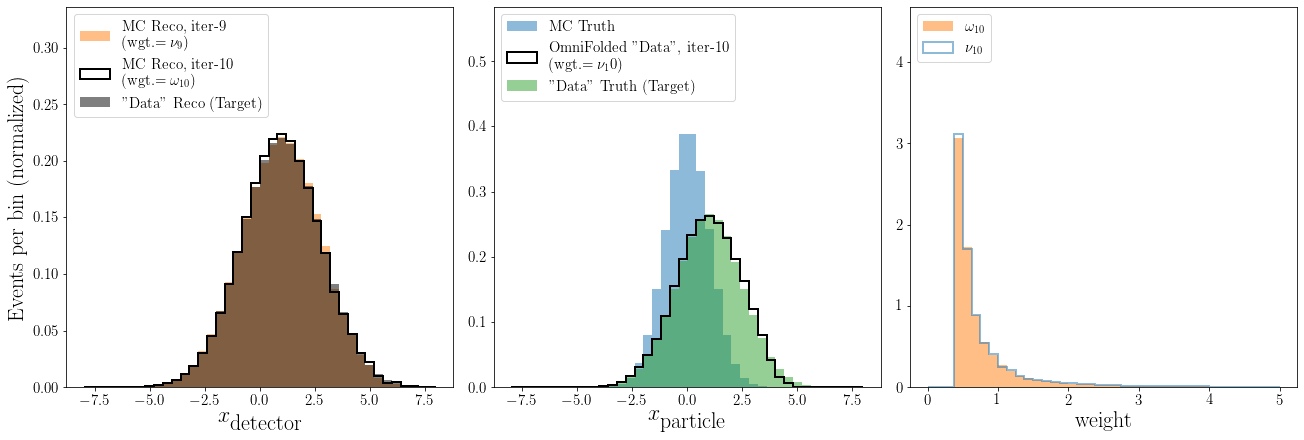

In [15]:
for i in range(iterations):
    print("ITERATION {}:".format(i + 1))

    fig, ax = plt.subplots(1, 3, figsize=(18, 6), constrained_layout=True)

    if i == 0:
        weights_init = np.ones(len(sim_reco))
        label0 = ''.format(i)
        label1 = ', iter-{}'.format(i + 1)
    else:
        weights_init = weights[i - 1, 1, :]
        label0 = ', iter-{}'.format(i)
        label1 = ', iter-{}'.format(i + 1)

    hR0, _, _ = ax[0].hist(sim_reco,
                           weights=weights_init,
                           bins=bins,
                           label='MC Reco' + label0 + '\n' +
                           r'(wgt.$=\nu_{{{}}}$)'.format(i),
                           **plot_style_2,
                           color='C1')

    hR1, _, _ = ax[0].hist(sim_reco,
                           bins=bins,
                           label='MC Reco' + label1 + '\n' +
                           r'(wgt.$=\omega_{{{}}}$)'.format(i + 1),
                           weights=weights[i, 0, :],
                           **plot_style_1)
    hR2, _, _ = ax[0].hist(data_reco,
                           bins=bins,
                           label='"Data" Reco (Target)',
                           **plot_style_2,
                           color='k')
    ax[0].set_xlabel(r"$x_{\textrm{detector}}$")
    ax[0].set_ylabel("Events per bin (normalized)")
    ax[0].legend(loc='upper left')
    ax[0].set_ylim([0, 1.5 * np.max(np.concatenate((hR0, hR1, hR2)))])

    hT0, _, _ = ax[1].hist(sim_truth,
                           bins=bins,
                           label=r'MC Truth',
                           **plot_style_2)

    hT1, _, _ = ax[1].hist(sim_truth,
                           weights=weights[i, 1, :],
                           bins=bins,
                           label='OmniFolded "Data"' + label1 + '\n' +
                           r'(wgt.$=\nu_{}$)'.format(i + 1),
                           **plot_style_1)
    hT2, _, _ = ax[1].hist(data_truth,
                           bins=bins,
                           label='"Data" Truth (Target)',
                           **plot_style_2,
                           color='C2')
    ax[1].legend(loc='upper left')
    ax[1].set_xlabel(r"$x_{\textrm{particle}}$")
    ax[1].set_ylim([0, 1.5 * np.max(np.concatenate((hT0, hT1, hT2)))])

    #     ax[0].set_ylim([0,1.5*np.max(np.concatenate((hT0, hT1, hT2, hR0, hR1,hR2)))])

    hWR, _, _ = ax[2].hist(weights[i, 0, :],
                           bins=weight_bins,
                           **plot_style_2,
                           color='C1',
                           label=r"$\omega_{{{}}}$".format(i + 1))
    hWT, _, _ = ax[2].hist(weights[i, 1, :],
                           bins=weight_bins,
                           **plot_style_3,
                           color='C0',
                           label=r"$\nu_{{{}}}$".format(i + 1))
    ax[2].set_xlabel('weight')
    ax[2].legend(loc='upper left')
    ax[2].set_ylim([0, 1.5 * np.max(np.concatenate((hWR, hWT)))])

    fig.show()
    fig.savefig(
        'SupportNote/figures/GaussianToyExample/GaussianToyExample-UnfoldingResultsIteration{:02}.pdf'
        .format(i + 1),
        bbox_inches='tight')
    plt.show()

### Unfold with initial MC weights

In [16]:
# increase number of iterations
iterations = 10

In [17]:
# initial iterative weights are MC weights

weights_pull = weights_MC_sim
weights_push = weights_MC_sim

weight_bins = np.linspace(-8, 8, 41)

In [18]:
# clear total weights

weights = np.empty(shape=(iterations, 2, len(sim)))
# shape = (iteration, step, event)

In [19]:
for i in range(iterations):
    print("\nITERATION: {}\n".format(i + 1))

    # STEP 1: classify MC Reco (which is reweighted by weights_push) to "Data" Reco
    # weights reweighted MC Reco --> "Data" Reco
    print("STEP 1\n")

    weights_1 = np.concatenate((weights_push, weights_MC_data))
    # actual weights for MC Reco, initial MC weights for "Data" Reco

    X_train_1, X_test_1, Y_train_1, Y_test_1, w_train_1, w_test_1 = train_test_split(
        xvals_1, yvals_1, weights_1)
    
    # zip ("hide") the weights with the labels
    Y_train_1 = np.stack((Y_train_1, w_train_1), axis=1)
    Y_test_1 = np.stack((Y_test_1, w_test_1), axis=1)

    model.compile(loss=weighted_binary_crossentropy,
                  optimizer='Adam',
                  metrics=['accuracy'])
    model.fit(X_train_1,
              Y_train_1,
              epochs=200,
              batch_size=batch_size,
              validation_data=(X_test_1, Y_test_1),
              callbacks=[earlystopping],
              verbose=1)

    weights_pull = weights_push * reweight(sim_reco)
    weights[i, :1, :] = weights_pull

    # STEP 2: classify MC Truth to reweighted MC Truth (which is reweighted by weights_pull)
    # weights MC Truth --> reweighted MC Truth
    print("\nSTEP 2\n")

    weights_2 = np.concatenate((weights_MC_sim, weights_pull))
    # initial MC weights for MC Truth, actual weights for (reweighted) MC Truth

    X_train_2, X_test_2, Y_train_2, Y_test_2, w_train_2, w_test_2 = train_test_split(
        xvals_2, yvals_2, weights_2)
    
    # zip ("hide") the weights with the labels
    Y_train_2 = np.stack((Y_train_2, w_train_2), axis=1)
    Y_test_2 = np.stack((Y_test_2, w_test_2), axis=1)

    model.compile(loss=weighted_binary_crossentropy,
                  optimizer='Adam',
                  metrics=['accuracy'])
    model.fit(X_train_2,
              Y_train_2,
              epochs=200,
              batch_size=batch_size,
              validation_data=(X_test_2, Y_test_2),
              callbacks=[earlystopping],
              verbose=1)

    # note we need to take into account MC weights when reweighting the synthetic MC Truth
    weights_push = weights_MC_sim * reweight(sim_truth)
    weights[i, 1:2, :] = weights_push


ITERATION: 1

STEP 1

Epoch 1/200
150/150 [==============================] - 1s 4ms/step - loss: 0.6177 - accuracy: 0.3088 - val_loss: 0.6179 - val_accuracy: 0.3070
Epoch 2/200
150/150 [==============================] - 0s 2ms/step - loss: 0.6156 - accuracy: 0.3079 - val_loss: 0.6175 - val_accuracy: 0.3079
Epoch 3/200
150/150 [==============================] - 0s 3ms/step - loss: 0.6157 - accuracy: 0.3080 - val_loss: 0.6176 - val_accuracy: 0.3072
Epoch 4/200
150/150 [==============================] - 0s 3ms/step - loss: 0.6157 - accuracy: 0.3081 - val_loss: 0.6177 - val_accuracy: 0.3070
Epoch 5/200
150/150 [==============================] - 0s 3ms/step - loss: 0.6156 - accuracy: 0.3079 - val_loss: 0.6176 - val_accuracy: 0.3085
Epoch 6/200
150/150 [==============================] - 0s 3ms/step - loss: 0.6156 - accuracy: 0.3080 - val_loss: 0.6175 - val_accuracy: 0.3082
Epoch 7/200
150/150 [==============================] - 0s 2ms/step - loss: 0.6156 - accuracy: 0.3080 - val_loss: 0.6175

150/150 [==============================] - 0s 2ms/step - loss: 0.6043 - accuracy: 0.2499 - val_loss: 0.6016 - val_accuracy: 0.2504
Epoch 6/200
150/150 [==============================] - 0s 2ms/step - loss: 0.6042 - accuracy: 0.2499 - val_loss: 0.6016 - val_accuracy: 0.2504
Epoch 7/200
150/150 [==============================] - 0s 2ms/step - loss: 0.6042 - accuracy: 0.2498 - val_loss: 0.6019 - val_accuracy: 0.2504
Epoch 8/200
150/150 [==============================] - 0s 2ms/step - loss: 0.6043 - accuracy: 0.2499 - val_loss: 0.6018 - val_accuracy: 0.2506
Epoch 9/200
150/150 [==============================] - 0s 2ms/step - loss: 0.6042 - accuracy: 0.2499 - val_loss: 0.6017 - val_accuracy: 0.2504
Epoch 10/200
150/150 [==============================] - 0s 2ms/step - loss: 0.6042 - accuracy: 0.2499 - val_loss: 0.6017 - val_accuracy: 0.2504
Epoch 11/200
150/150 [==============================] - 0s 2ms/step - loss: 0.6043 - accuracy: 0.2499 - val_loss: 0.6017 - val_accuracy: 0.2504
Epoch 12/

150/150 [==============================] - 0s 2ms/step - loss: 1.0054 - accuracy: 0.2511 - val_loss: 1.0090 - val_accuracy: 0.2653
Epoch 11/200
150/150 [==============================] - 0s 2ms/step - loss: 1.0062 - accuracy: 0.2528 - val_loss: 1.0057 - val_accuracy: 0.2416
Epoch 12/200
150/150 [==============================] - 0s 2ms/step - loss: 1.0057 - accuracy: 0.2525 - val_loss: 1.0055 - val_accuracy: 0.2442
Epoch 00012: early stopping

STEP 2

Epoch 1/200
150/150 [==============================] - 0s 3ms/step - loss: 0.5797 - accuracy: 0.2501 - val_loss: 0.5594 - val_accuracy: 0.2500
Epoch 2/200
150/150 [==============================] - 0s 2ms/step - loss: 0.5558 - accuracy: 0.2500 - val_loss: 0.5594 - val_accuracy: 0.2499
Epoch 3/200
150/150 [==============================] - 0s 2ms/step - loss: 0.5559 - accuracy: 0.2500 - val_loss: 0.5594 - val_accuracy: 0.2499
Epoch 4/200
150/150 [==============================] - 0s 3ms/step - loss: 0.5558 - accuracy: 0.2500 - val_loss: 0.

150/150 [==============================] - 0s 2ms/step - loss: 1.0183 - accuracy: 0.2455 - val_loss: 1.0229 - val_accuracy: 0.2470
Epoch 3/200
150/150 [==============================] - 0s 2ms/step - loss: 1.0190 - accuracy: 0.2357 - val_loss: 1.0243 - val_accuracy: 0.2569
Epoch 4/200
150/150 [==============================] - 0s 2ms/step - loss: 1.0182 - accuracy: 0.2491 - val_loss: 1.0230 - val_accuracy: 0.2018
Epoch 5/200
150/150 [==============================] - 0s 2ms/step - loss: 1.0180 - accuracy: 0.2278 - val_loss: 1.0233 - val_accuracy: 0.2612
Epoch 6/200
150/150 [==============================] - 0s 2ms/step - loss: 1.0189 - accuracy: 0.2361 - val_loss: 1.0233 - val_accuracy: 0.2228
Epoch 7/200
150/150 [==============================] - 0s 2ms/step - loss: 1.0182 - accuracy: 0.2524 - val_loss: 1.0244 - val_accuracy: 0.2267
Epoch 8/200
150/150 [==============================] - 0s 2ms/step - loss: 1.0175 - accuracy: 0.2281 - val_loss: 1.0232 - val_accuracy: 0.2389
Epoch 9/200

Epoch 8/200
150/150 [==============================] - 0s 3ms/step - loss: 0.5425 - accuracy: 0.2502 - val_loss: 0.5432 - val_accuracy: 0.2495
Epoch 9/200
150/150 [==============================] - 0s 3ms/step - loss: 0.5425 - accuracy: 0.2502 - val_loss: 0.5433 - val_accuracy: 0.2496
Epoch 10/200
150/150 [==============================] - 0s 3ms/step - loss: 0.5425 - accuracy: 0.2502 - val_loss: 0.5433 - val_accuracy: 0.2495
Epoch 11/200
150/150 [==============================] - 0s 3ms/step - loss: 0.5425 - accuracy: 0.2502 - val_loss: 0.5432 - val_accuracy: 0.2495
Epoch 12/200
150/150 [==============================] - 0s 3ms/step - loss: 0.5425 - accuracy: 0.2501 - val_loss: 0.5432 - val_accuracy: 0.2495
Epoch 13/200
150/150 [==============================] - 0s 2ms/step - loss: 0.5425 - accuracy: 0.2501 - val_loss: 0.5432 - val_accuracy: 0.2495
Epoch 14/200
150/150 [==============================] - 0s 2ms/step - loss: 0.5425 - accuracy: 0.2501 - val_loss: 0.5432 - val_accuracy: 0

150/150 [==============================] - 0s 2ms/step - loss: 1.0194 - accuracy: 0.2590 - val_loss: 1.0180 - val_accuracy: 0.2668
Epoch 6/200
150/150 [==============================] - 0s 2ms/step - loss: 1.0194 - accuracy: 0.2734 - val_loss: 1.0148 - val_accuracy: 0.2585
Epoch 7/200
150/150 [==============================] - 0s 3ms/step - loss: 1.0195 - accuracy: 0.2650 - val_loss: 1.0154 - val_accuracy: 0.2992
Epoch 8/200
150/150 [==============================] - 0s 3ms/step - loss: 1.0193 - accuracy: 0.2633 - val_loss: 1.0149 - val_accuracy: 0.2919
Epoch 9/200
150/150 [==============================] - 0s 3ms/step - loss: 1.0196 - accuracy: 0.2653 - val_loss: 1.0179 - val_accuracy: 0.2519
Epoch 10/200
150/150 [==============================] - 0s 3ms/step - loss: 1.0198 - accuracy: 0.2620 - val_loss: 1.0159 - val_accuracy: 0.2774
Epoch 11/200
150/150 [==============================] - 0s 3ms/step - loss: 1.0193 - accuracy: 0.2679 - val_loss: 1.0148 - val_accuracy: 0.2574
Epoch 12/

150/150 [==============================] - 0s 2ms/step - loss: 0.5578 - accuracy: 0.2500 - val_loss: 0.5582 - val_accuracy: 0.2497
Epoch 15/200
150/150 [==============================] - 0s 2ms/step - loss: 0.5578 - accuracy: 0.2501 - val_loss: 0.5583 - val_accuracy: 0.2497
Epoch 16/200
150/150 [==============================] - 0s 2ms/step - loss: 0.5578 - accuracy: 0.2501 - val_loss: 0.5582 - val_accuracy: 0.2497
Epoch 17/200
150/150 [==============================] - 0s 2ms/step - loss: 0.5578 - accuracy: 0.2501 - val_loss: 0.5583 - val_accuracy: 0.2497
Epoch 18/200
150/150 [==============================] - 0s 2ms/step - loss: 0.5578 - accuracy: 0.2501 - val_loss: 0.5589 - val_accuracy: 0.2498
Epoch 19/200
150/150 [==============================] - 0s 2ms/step - loss: 0.5578 - accuracy: 0.2501 - val_loss: 0.5582 - val_accuracy: 0.2497
Epoch 20/200
150/150 [==============================] - 0s 2ms/step - loss: 0.5578 - accuracy: 0.2501 - val_loss: 0.5582 - val_accuracy: 0.2497
Epoch

#### Results

ITERATION 1:


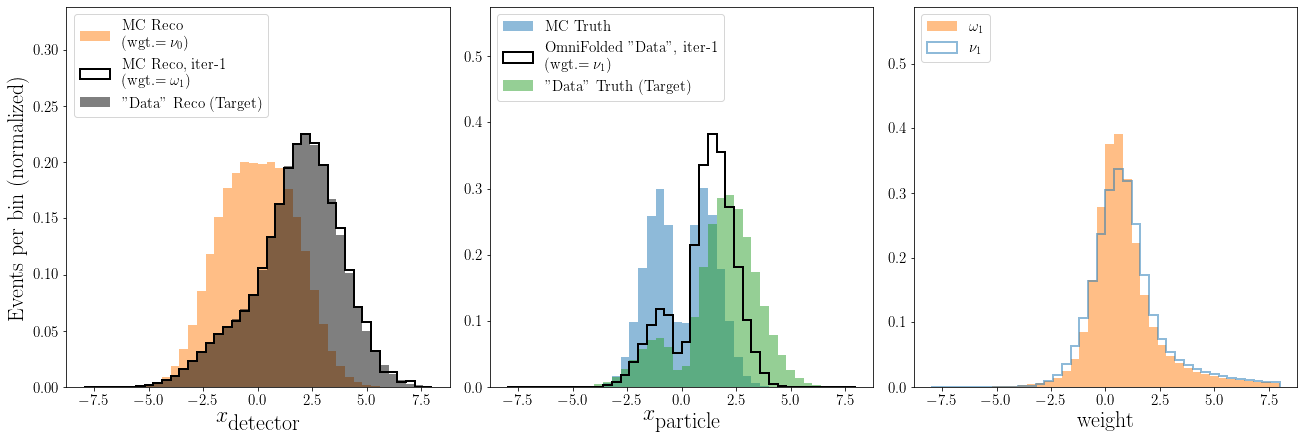

ITERATION 2:


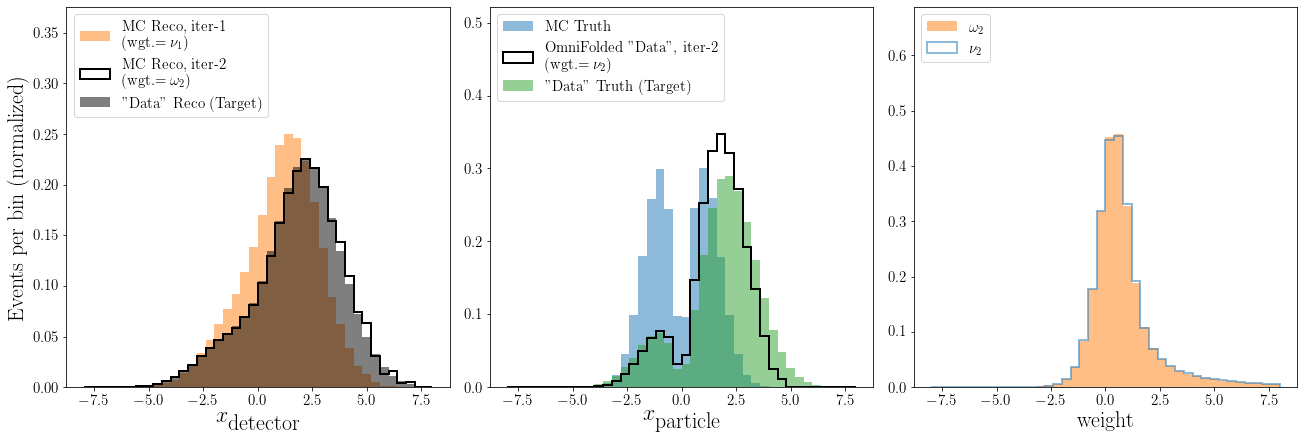

ITERATION 3:


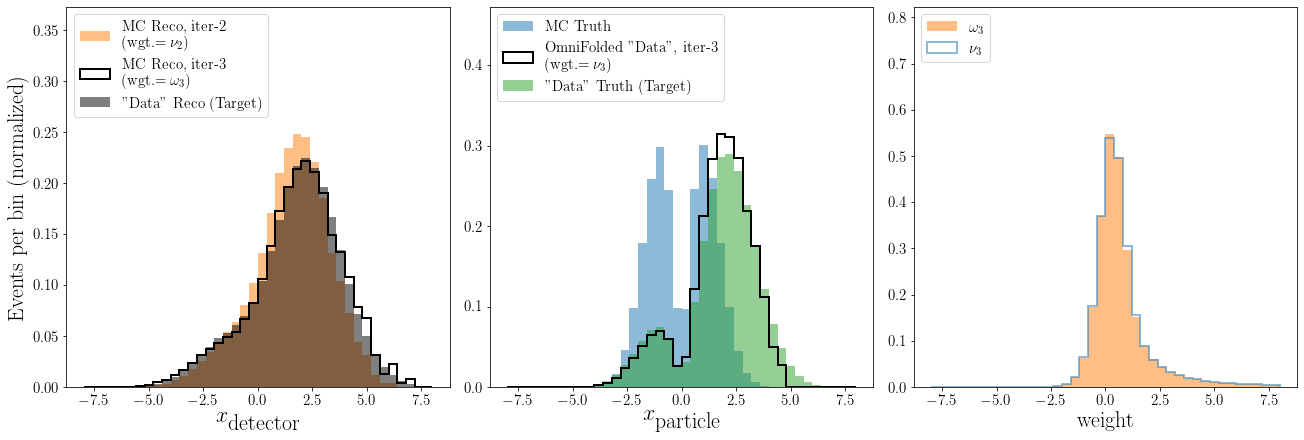

ITERATION 4:


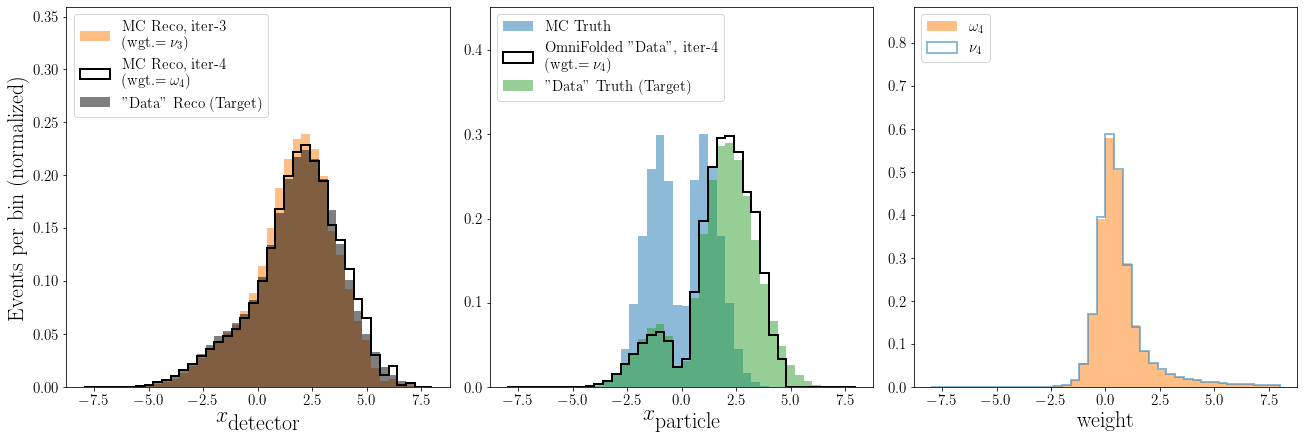

ITERATION 5:


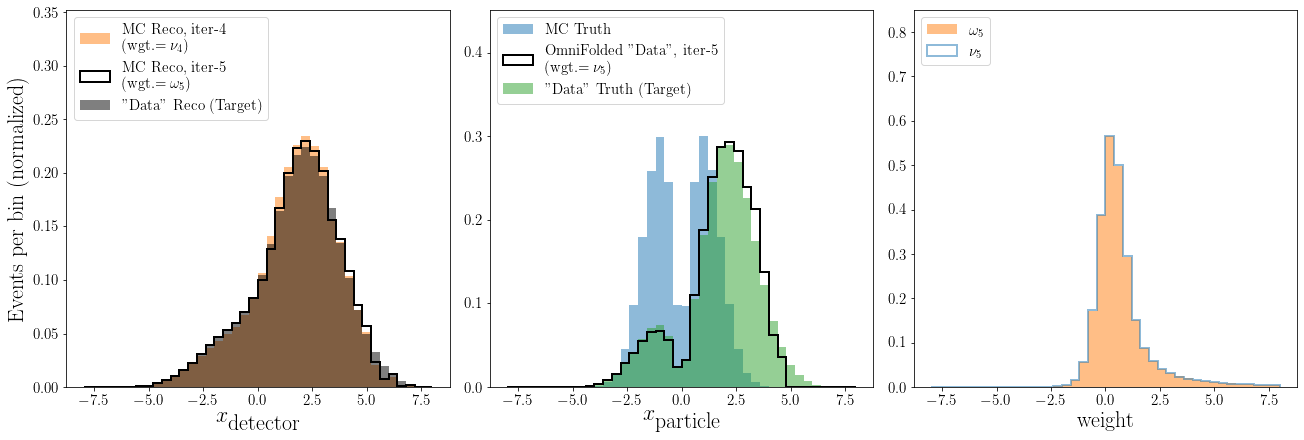

ITERATION 6:


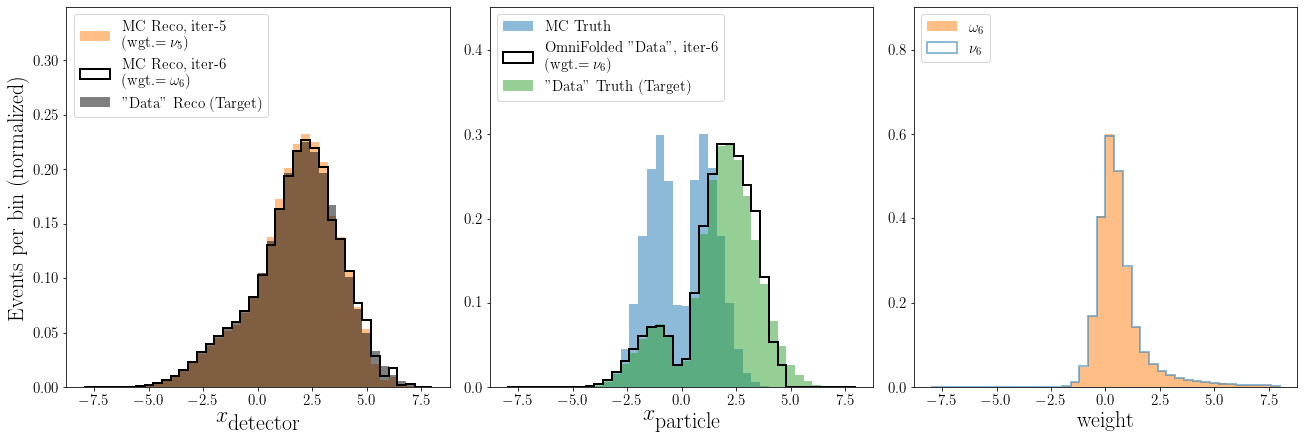

ITERATION 7:


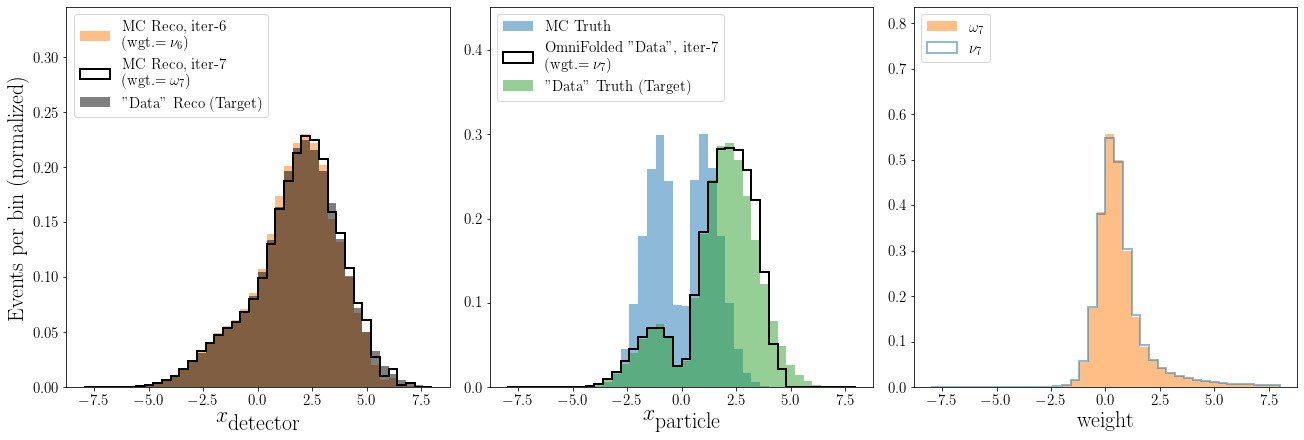

ITERATION 8:


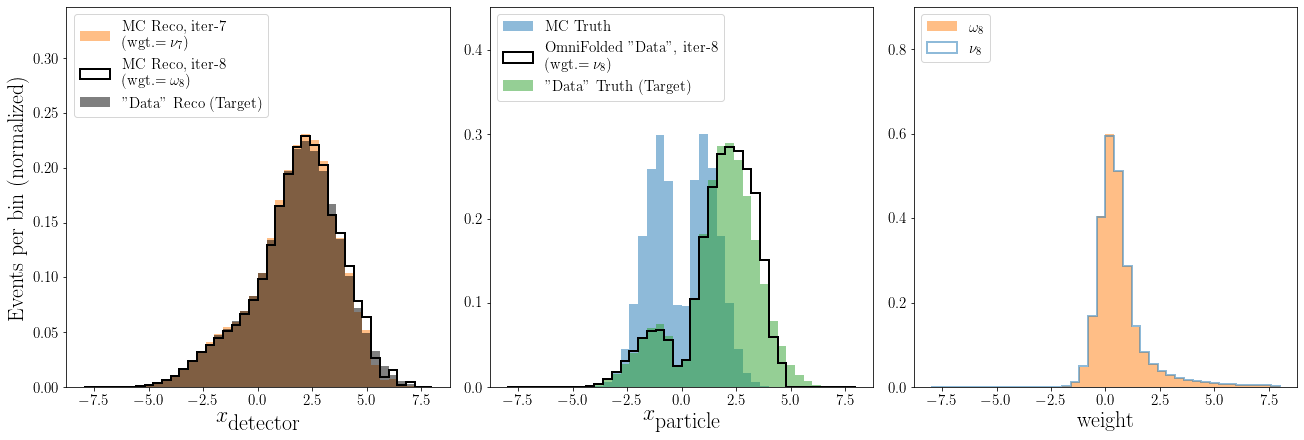

ITERATION 9:


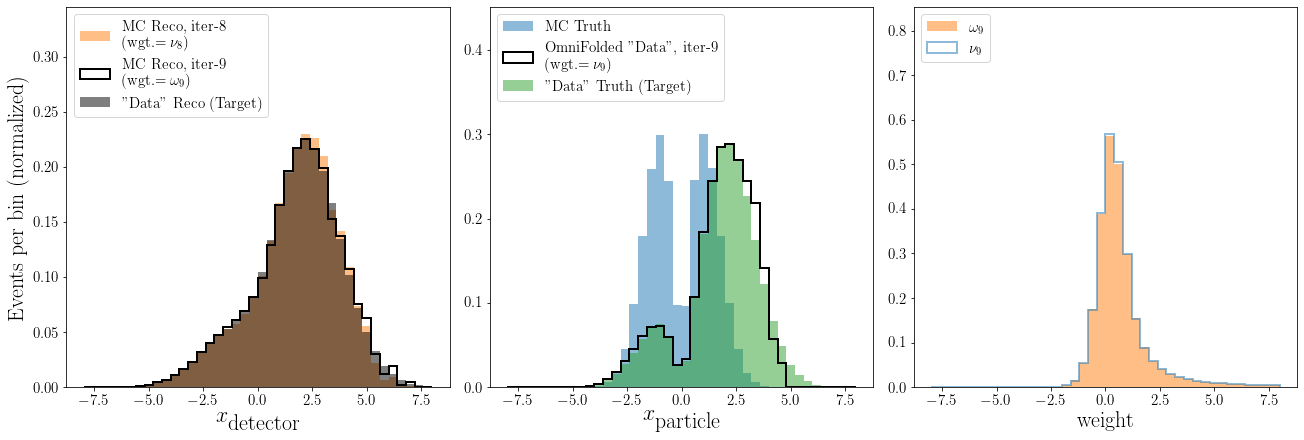

ITERATION 10:


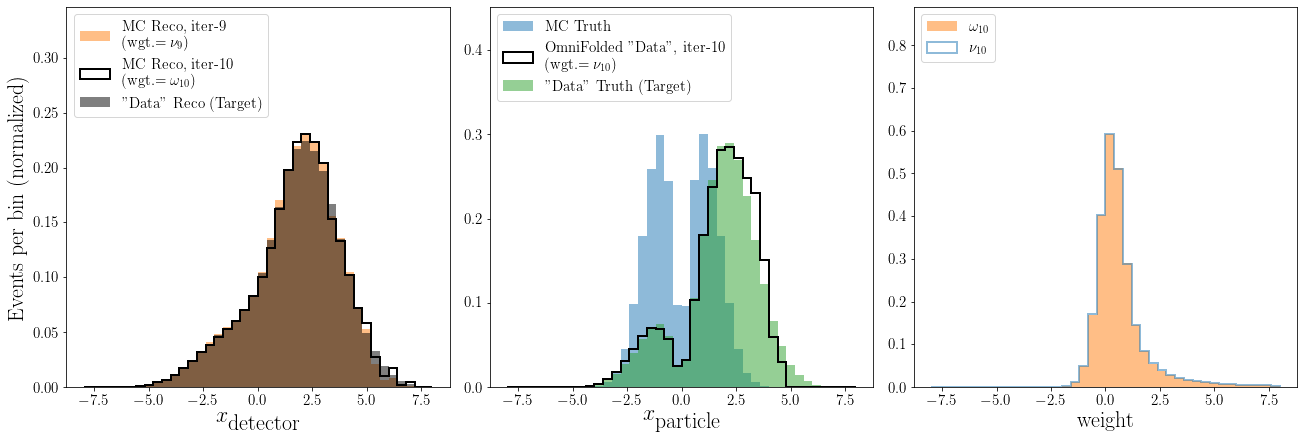

In [20]:
for i in range(iterations):
    print("ITERATION {}:".format(i + 1))

    fig, ax = plt.subplots(1,
                           3,
                           figsize=(18, 6),
                           constrained_layout=True,
                           sharey=False)

    if i == 0:
        weights_init = weights_MC_sim
        label0 = ''.format(i)
        label1 = ', iter-{}'.format(i + 1)
    else:
        weights_init = weights[i - 1, 1, :]
        label0 = ', iter-{}'.format(i)
        label1 = ', iter-{}'.format(i + 1)

    hT0, _, _ = ax[0].hist(sim_reco,
                           weights=weights_init,
                           bins=bins,
                           label='MC Reco' + label0 + '\n' +
                           r'(wgt.$=\nu_{{{}}}$)'.format(i),
                           **plot_style_2,
                           color='C1')

    hT1, _, _ = ax[0].hist(sim_reco,
                           bins=bins,
                           label='MC Reco' + label1 + '\n' +
                           r'(wgt.$=\omega_{{{}}}$)'.format(i + 1),
                           weights=weights[i, 0, :],
                           **plot_style_1)
    hT2, _, _ = ax[0].hist(data_reco,
                           weights=weights_MC_data,
                           bins=bins,
                           label='"Data" Reco (Target)',
                           **plot_style_2,
                           color='k')
    ax[0].set_xlabel(r"$x_{\textnormal{detector}}$")
    ax[0].set_ylabel("Events per bin (normalized)")
    ax[0].legend(loc='upper left')
    ax[0].set_ylim([0, 1.5 * np.max(np.concatenate((hT0, hT1, hT2)))])
    hR0, _, _ = ax[1].hist(sim_truth,
                           weights=weights_MC_sim,
                           bins=bins,
                           label=r'MC Truth',
                           **plot_style_2)

    hR1, _, _ = ax[1].hist(sim_truth,
                           weights=weights[i, 1, :],
                           bins=bins,
                           label='OmniFolded "Data"' + label1 + '\n' +
                           r'(wgt.$=\nu_{{{}}}$)'.format(i + 1),
                           **plot_style_1)
    hR2, _, _ = ax[1].hist(data_truth,
                           weights=weights_MC_data,
                           bins=bins,
                           label='"Data" Truth  (Target)',
                           **plot_style_2,
                           color='C2')
    ax[1].legend(loc='upper left')
    ax[1].set_xlabel(r"$x_{\textnormal{particle}}$")
    ax[1].set_ylim([0, 1.5 * np.max(np.concatenate((hR0, hR1, hR2)))])

    #     ax[0].set_ylim(
    #         [0, 1.5 * np.max(np.concatenate((hT0, hT1, hT2, hR0, hR1, hR2)))])
    hWR, _, _ = ax[2].hist(weights[i, 0, :],
                           bins=weight_bins,
                           **plot_style_2,
                           color='C1',
                           label=r"$\omega_{{{}}}$".format(i + 1))
    hWT, _, _ = ax[2].hist(weights[i, 1, :],
                           bins=weight_bins,
                           **plot_style_3,
                           color='C0',
                           label=r"$\nu_{{{}}}$".format(i + 1))
    ax[2].set_xlabel('weight')
    ax[2].legend(loc='upper left')
    ax[2].set_ylim([0, 1.5 * np.max(np.concatenate((hWR, hWT)))])

    fig.show()
    fig.savefig(
        'SupportNote/figures/GaussianToyExample/GaussianToyExample-MCUnfoldingResultsIteration{:02}.pdf'
        .format(i + 1),
        bbox_inches='tight')
    plt.show()